In [117]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
import scipy.integrate as integrate
import scipy.optimize as optimize
from scipy import interpolate
import ternary

In [44]:
import copy 

In [3]:
# numpy
# pandas

class build_mesh_ternary:
##"build mesh grid for pseudo-ternary diagram"
# input is increment, and composition range for the pseudo ternary components
# generate evenly spaced concentration points for the pseudo ternary components (psA, psB, and psC)
# then for each pseudo ternary component, assign the elemental concentration according to the ratio

# e.g. psA = CoNi,
#      psA_elements: Co, Ni, 
#      psA_ratio: 1:1
#
    def __init__(self,increment,
                 psA_range,
                 psB_range,
                 psC_range,
                 psA_elements,
                 psB_elements,
                 psC_elements,
                 psA_ratio,
                 psB_ratio,
                 psC_ratio):
        if float(increment) <=0:
            print('error: increment should be positive float')
            quit()
        self.increment = float(increment)
        self.psA_range = psA_range
        self.psB_range = psB_range
        self.psC_range = psC_range
        
        self.psA_elements = psA_elements
        self.psB_elements = psB_elements
        self.psC_elements = psC_elements
        
        self.psA_ratio = np.array(psA_ratio)
        self.psB_ratio = np.array(psB_ratio)
        self.psC_ratio = np.array(psC_ratio)
        
        
    def make_mesh(self):
        self.comp_psA = []
        self.comp_psB = []
        self.comp_psC = []
        a1 = np.arange(0,100,self.increment);
        a1 = np.append(a1,100)
        for i in a1:
            a2 = np.arange(0,100-i,self.increment)
            a2 = np.append(a2,100-i)
            for j in a2:
                self.comp_psA.append(i)
                self.comp_psB.append(j)
                self.comp_psC.append(100-i-j)
        comp_tmp = pd.DataFrame(
            data={
                    "comp(psA)":self.comp_psA,
                    "comp(psB)":self.comp_psB,
                    "comp(psC)":self.comp_psC
                 })
        
        self.comp = comp_tmp[(comp_tmp['comp(psA)']>=self.psA_range[0]) & (comp_tmp['comp(psA)']<=self.psA_range[1])
                            &(comp_tmp['comp(psB)']>=self.psB_range[0]) & (comp_tmp['comp(psB)']<=self.psB_range[1])
                            &(comp_tmp['comp(psC)']>=self.psC_range[0]) & (comp_tmp['comp(psC)']<=self.psC_range[1])]
        
        return self.comp
    
    def comp_assign(self):
    # assign psA to psA_elements according to psA_ratio
    # assign psB to psB_elements according to psB_ratio
    # assign psC to psC_elements according to psC_ratio
    # e.g. 
    # if psA_elements = ['Co','Ni','Cr'], psA_ratio = [1,1,2]
    # when psA = 40 at.%, Co = 10 at.%, Ni = 10 at.%, Cr = 20 at.%
        self.comp_elements = pd.DataFrame(data={})
        self.comp_psA_elements = [self.comp['comp(psA)']*self.psA_ratio[i]/sum(self.psA_ratio) for i in range(len(self.psA_ratio))]
        self.comp_psB_elements = [self.comp['comp(psB)']*self.psB_ratio[i]/sum(self.psB_ratio) for i in range(len(self.psB_ratio))]
        self.comp_psC_elements = [self.comp['comp(psC)']*self.psC_ratio[i]/sum(self.psC_ratio) for i in range(len(self.psC_ratio))]
        
        for i in range(len(self.psA_elements)):
            self.comp[self.psA_elements[i]] = self.comp_psA_elements[i]
            self.comp_elements[self.psA_elements[i]] = self.comp_psA_elements[i]
        for i in range(len(self.psB_elements)):
            self.comp[self.psB_elements[i]] = self.comp_psB_elements[i]
            self.comp_elements[self.psB_elements[i]] = self.comp_psB_elements[i]
        for i in range(len(self.psC_elements)):
            self.comp[self.psC_elements[i]] = self.comp_psC_elements[i]
            self.comp_elements[self.psC_elements[i]] = self.comp_psC_elements[i]
        
        self.comp_new = self.comp.reset_index(drop=True)
        self.comp_elements_new = self.comp_elements.reset_index(drop=True)
        return self.comp_new, self.comp_elements_new

In [196]:
import os
import json

class read_json_Suzuki_model_RWASM_ternary:
    
    def __init__(self,fh):
        if os.path.isfile(fh):
            self.file = fh
            self.data = json.load(open(fh))
        else:
            print('input file not in current directory')
            quit()
        
        self.model = self.data["model"]
        self.name = self.data["material"]
        # properties
        self.element_data = self.data['elements']
        # adjustable scalers
        self.adjustable_scalers = self.data['adjustables']
        # exp conditions
        self.experiment_conditions = self.data['conditions']
        # output file
        try: 
            self.savefilename = self.data['savefile']
        except:
            self.savefilename = self.data["material"] + '_out'
        # ternary 
        self.psA_elements = self.data['pseudo-ternary']['psA']['grouped_elements']
        self.psB_elements = self.data['pseudo-ternary']['psB']['grouped_elements']
        self.psC_elements = self.data['pseudo-ternary']['psC']['grouped_elements']
        
        self.psA_ratio = self.data['pseudo-ternary']['psA']['ratio']
        self.psB_ratio = self.data['pseudo-ternary']['psB']['ratio']
        self.psC_ratio = self.data['pseudo-ternary']['psC']['ratio']
        
        self.psA_range = self.data['pseudo-ternary']['psA']['range']
        self.psB_range = self.data['pseudo-ternary']['psB']['range']
        self.psC_range = self.data['pseudo-ternary']['psC']['range']
        
        self.increment = self.data['pseudo-ternary']['increment']
        

In [206]:
class Suzuki_model_RWASM_ternary:
    
    def __init__(self,
                element_data,
                comp_elements,comp_pst,
                experiment_conditions,
                adjustable_scalers):
        
        # 
        self.element_composition = comp_elements
        self.element_data = element_data
        self.comp_pst = comp_pst
        # conditions
        self.strain_r = experiment_conditions['strain_r']
        self.T = experiment_conditions['temperature']
        
        # constants
        self.boltzmann_J = 1.380649e-23
        self.boltzmann_eV = 8.617333262145e-5
        self.J2eV = self.boltzmann_eV/self.boltzmann_J
        self.eV2J = 1/self.J2eV
        self.Debye = 5 * 10**(12) # Debye frequency /s
        self.kT = self.boltzmann_J * self.T
        #adjustables
        self.rho = adjustable_scalers['dislocation_density']
        self.tau_i_exponent = adjustable_scalers['tau_i_exponent']
        self.trial_kappa_range = np.arange(adjustable_scalers['trial_kappa']['min'],
                                          adjustable_scalers['trial_kappa']['max']+adjustable_scalers['trial_kappa']['inc'],
                                          adjustable_scalers['trial_kappa']['inc'])
        self.trial_tau_k = adjustable_scalers['trial_tau_k'] * 1e6
        self.kink_width = adjustable_scalers['kink_width']

        
        
    def L(self,kappa_i):
        f = lambda x: np.exp(-x**2/2)/np.sqrt(2*np.pi)
        y = integrate.quad(f,kappa_i,np.inf)
        return self.b/(3*y[0]*self.c) 
    
    def tau_y_optimize(self,x):
        self.tau_j = lambda kappa_i: (self.E_int + self.E_vac)/(4*self.b*self.L(kappa_i))
        
        self.Delta_V = lambda x: 3 * x[1]**2 * self.E_w**2 * self.c / (2*x[0]**2*self.a_p*self.b**2) + \
                                     x[0]**2 * self.a_p**3 * self.b**4 * self.lambda_k**2 / (6*x[1]**2 * self.E_w**2 * self.c)
        self.S = lambda x: 18 * x[1]**2 * self.E_w**2 * self.c *self.kT /(self.a_p**3 * self.b**4 * self.lambda_k**2) * \
                 np.log( (5*np.pi*self.kT)**2 * self.Debye * self.a_p * self.b /((self.G*self.b*self.Delta_V(x))**2 * self.strain_r) )
        self.R = lambda kappa_i: 27 * kappa_i**4 * self.E_w**4 * self.c**2 / (self.a_p**4 * self.b**6 * self.lambda_k**2)
        # x[0] = tau_k
        # x[1] = kappa_i
        #self.tau_k_opt_func = lambda x: x[0]**4 + x[0]*self.S(x) - self.R(x[1]) 
        self.tau_y_funcs = lambda x: (self.tau_j(x[1]) + x[0], x[0]**4 + x[0]*self.S(x) - self.R(x[1]))
        self.res = optimize.root(self.tau_y_funcs, x)
        self.tau_k_value = self.res.x[0]
        self.tau_y_value = (self.res.x[0]) + self.tau_j(self.res.x[1])
        self.tau_j_value = self.tau_j(self.res.x[1])
        self.L_value = self.L(self.res.x[1])
        
    
    def phenomelogical_model_tau_y(self): 
        # tau_y = ( sum( tau_y_i**(1/q) ) )**q
        self.tau_y_tot = [sum(tau_y_i**(1/self.tau_i_exponent))**self.tau_i_exponent for tau_y_i in self.tau_y_i_pst]
        
    def calculate(self):
        self.tau_y_i_pst = [] # record all compositions shape(len(composition),len(element))
        tau_y_i_pst = []
        for i in range(len(self.element_composition)):
            
            # record tau_y for every element at composition i
            tau_y_i = []
            for element_symbol in self.element_composition.columns:
                element_i = self.element_data[element_symbol]
                #print(element_i)
                # calculate the yield strength contribution for every element
                # according to concentration
                # setup properties for every element
                self.c = self.element_composition[element_symbol][i]/100
                if self.c == 0:
                    tau_y_i.append(0)
                    continue
                self.E_f_v = element_i['E_f_v'] * self.eV2J #J
                self.E_f_si = element_i['E_f_si'] * self.eV2J # J
                self.a_0 = element_i['a']*1e-10#element_i['a_0'] * 10**(-10) # unit: m
                self.E_w = element_i['E_w'] * self.eV2J#element_i['E_w'] * self.eV2J # J
                
                self.G = element_i['G'] * 10**9 # Pa
                self.nu = element_i['nu']
                self.b = self.a_0 * np.sqrt(3) / 2
                self.a_p = self.a_0 * np.sqrt(2/3)
                #self.E_vac = 0.6 * self.eV2J / 10**(-10) # test NbTiZr
                #self.E_int = 0.9 * self.eV2J / 10**(-10) # test NbTiZr
                self.E_vac = 0.707 * self.E_f_v  /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
                self.E_int = 0.707 * self.E_f_si /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
                self.lambda_k = self.b * self.kink_width
                
                # record the optimization results for post-processing
                tau_k_list = []
                tau_j_list = []
                tau_y_list = []
                optimized_kappa_list = []
                
                # start to optimize tau_k for every trial kappa
                for trial_kappa_i in (self.trial_kappa_range):
                    
                    x_trial = [self.trial_tau_k, trial_kappa_i]
                    self.tau_y_optimize(x_trial)
                    tau_k_list.append(self.tau_k_value/1e6)
                    tau_j_list.append(self.tau_j_value/1e6)
                    tau_y_list.append(self.tau_y_value/1e6)
                    optimized_kappa_list.append((self.res.x[1]))
                
                # optimize tau_y over kappa, this finds the true tau_y for each element
                optimized_kappa_sort, tau_y_sort, tau_j_sort, tau_k_sort  = zip(*sorted(zip(optimized_kappa_list, tau_y_list, tau_j_list, tau_k_list)))

                '''
                # polyfit tau_y over kappa_i, then find minimum of the polyfit
                # this is because the kappa_list and tau_y_list are discrete points and maybe noisy, 
                # need a smooth curve to find min
                polyfit = np.polyfit(optimized_kappa_sort, tau_y_sort,9)
                npfit = np.poly1d(polyfit)
                guess_kappa = (self.trial_kappa_range[0]+self.trial_kappa_range[1])/2
                optimized_kappa = optimize.fmin_slsqp(npfit,guess_kappa,
                                                      bounds=([(self.trial_kappa_range[0],self.trial_kappa_range[-1])]))
                if self.T == 300:
                    plt.plot(optimized_kappa_sort, tau_y_sort)
                    print('optimized_kappa:',optimized_kappa)
                    plt.ylim(0,500)
                    plt.plot(self.trial_kappa_range,npfit(self.trial_kappa_range))
                # record tau_y for every element
                tau_y_i.append(npfit(optimized_kappa[0]))''' # doesn't work very well, need a better way. np.polyfit gets weird shape
                # tau_y_i contains tau_y values for every element at composition i
                tau_y_i.append(min(tau_y_sort)) # just live with that...
            
            self.tau_y_i = np.array(tau_y_i)
            
            tau_y_i_pst.append(self.tau_y_i)
        self.tau_y_i_pst = np.array(tau_y_i_pst)
        self.phenomelogical_model_tau_y()
        
    def writedata(self):
        self.calc_data = copy.deepcopy(self.comp_pst)
        for idx in range(len(self.element_composition.columns)):
            self.calc_data['tau_y_'+self.element_composition.columns[idx]] = np.round(self.tau_y_i_pst.transpose()[idx],2)
        self.calc_data['T'] = np.ones(len(self.calc_data)) * self.T
        self.calc_data['tau_y'] = np.round(self.tau_y_tot,2)

In [207]:
input_data = read_json_Suzuki_model_RWASM_ternary('../sample_input_TiNbZr_BCC_screw_suzuki_ternary.json')


In [208]:

mesh = build_mesh_ternary(input_data.increment,
                          input_data.psA_range,
                          input_data.psB_range,
                          input_data.psC_range,
                          input_data.psA_elements,
                          input_data.psB_elements,
                          input_data.psC_elements,
                          input_data.psA_ratio,
                          input_data.psB_ratio,
                          input_data.psC_ratio)
comp_tmp = mesh.make_mesh()
comp_pst, comp_elements = mesh.comp_assign()
comp_pst

,comp(psA),comp(psB),comp(psC),Nb,Ti,Zr
0,0.0,0.0,100.0,0.0,0.0,100.0
1,0.0,5.0,95.0,0.0,5.0,95.0
2,0.0,10.0,90.0,0.0,10.0,90.0
3,0.0,15.0,85.0,0.0,15.0,85.0
4,0.0,20.0,80.0,0.0,20.0,80.0
...,...,...,...,...,...,...
226,90.0,5.0,5.0,90.0,5.0,5.0
227,90.0,10.0,0.0,90.0,10.0,0.0
228,95.0,0.0,5.0,95.0,0.0,5.0
229,95.0,5.0,0.0,95.0,5.0,0.0


In [209]:
model = Suzuki_model_RWASM_ternary(
                input_data.element_data,
                comp_elements,comp_pst,
                input_data.experiment_conditions,
                input_data.adjustable_scalers)

In [210]:
model.calculate()

In [211]:
model.writedata()

In [212]:
mask=model.calc_data['Nb']==35
model.calc_data[mask]

,comp(psA),comp(psB),comp(psC),Nb,Ti,Zr,tau_y_Nb,tau_y_Ti,tau_y_Zr,T,tau_y
126,35.0,0.0,65.0,35.0,0.0,65.0,176.73,0.00,230.60,300.0,407.33
127,35.0,5.0,60.0,35.0,5.0,60.0,176.73,9.87,212.62,300.0,399.23
128,35.0,10.0,55.0,35.0,10.0,55.0,176.73,18.77,196.24,300.0,391.73
129,35.0,15.0,50.0,35.0,15.0,50.0,176.73,27.35,179.59,300.0,383.68
130,35.0,20.0,45.0,35.0,20.0,45.0,176.73,35.75,162.81,300.0,375.30
131,35.0,25.0,40.0,35.0,25.0,40.0,176.73,44.02,146.71,300.0,367.46
132,35.0,30.0,35.0,35.0,30.0,35.0,176.73,52.17,128.80,300.0,357.70
133,35.0,35.0,30.0,35.0,35.0,30.0,176.73,60.23,112.88,300.0,349.84
134,35.0,40.0,25.0,35.0,40.0,25.0,176.73,68.24,94.44,300.0,339.41
135,35.0,45.0,20.0,35.0,45.0,20.0,176.73,76.16,76.57,300.0,329.46


In [213]:
points = model.calc_data[model.calc_data.columns[:3]].apply(tuple, axis=1)
heatmap_dict =  dict(zip(points, np.round(model.calc_data['tau_y'],2)))


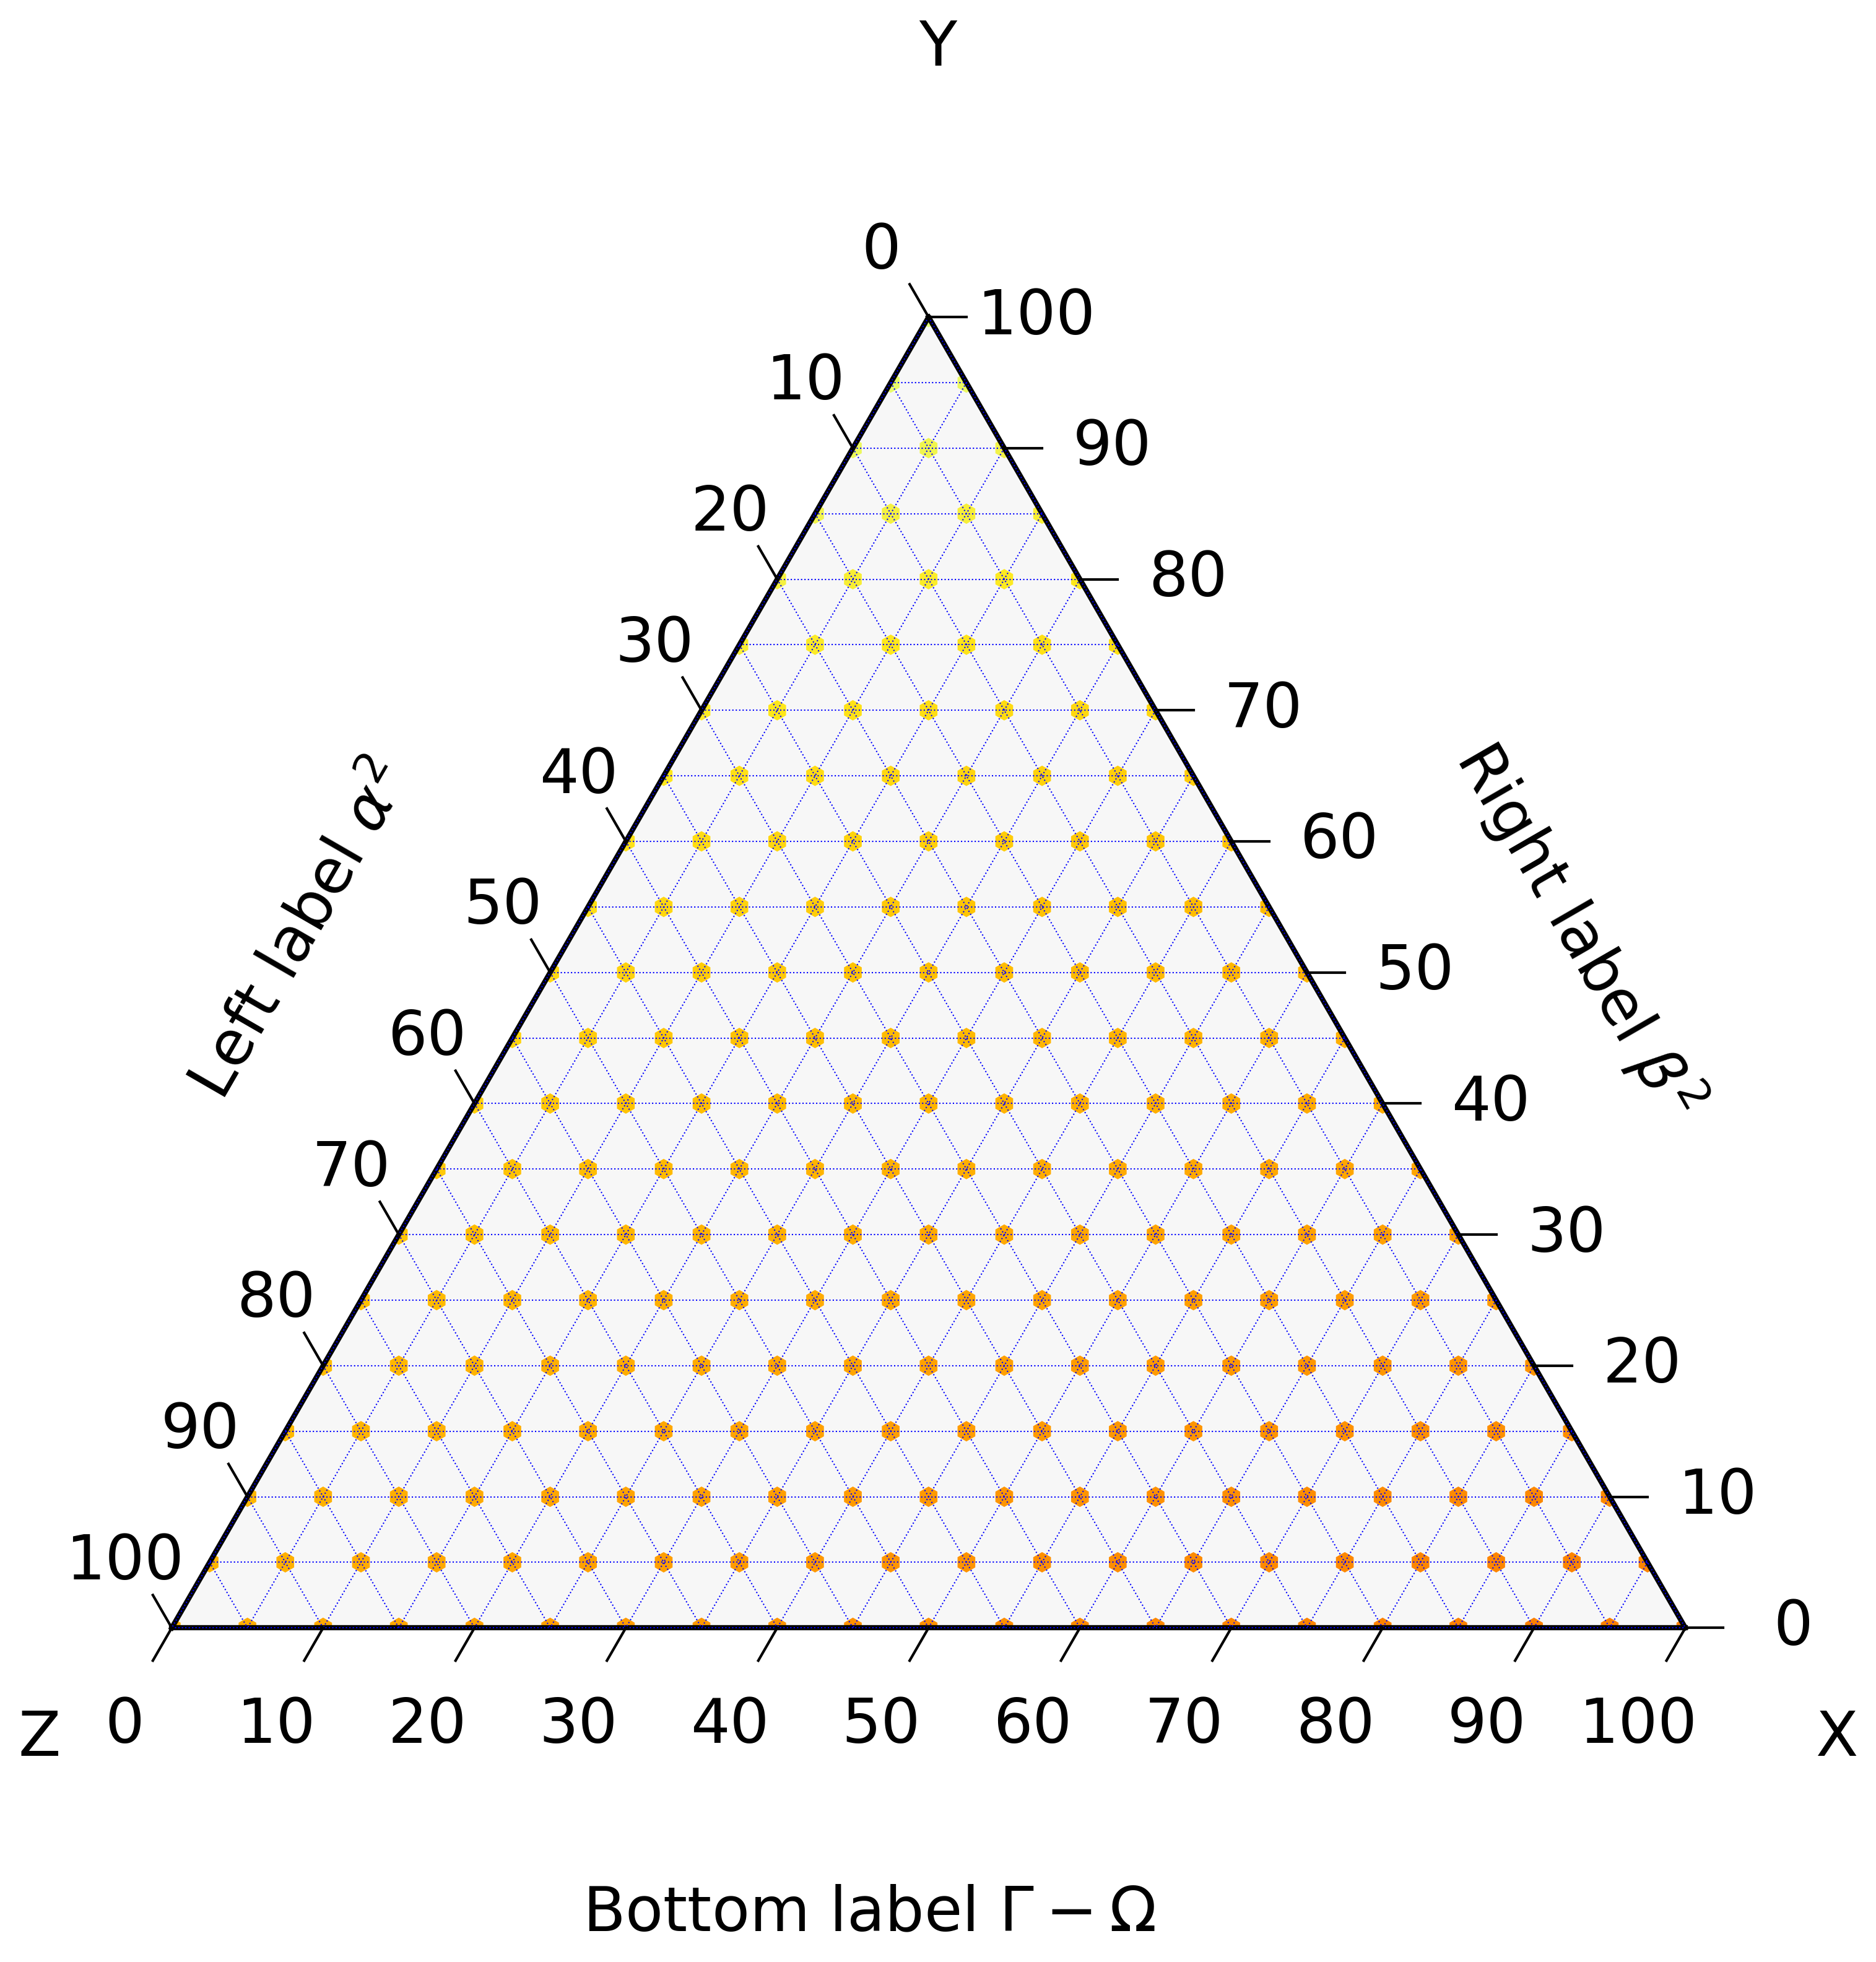

In [214]:
fig = ternary.plt.figure(figsize=(12,12),dpi=300)
ax1 = fig.add_subplot(1, 1, 1)


tax = ternary.TernaryAxesSubplot(ax=ax1, scale=100)
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

fontsize = 24
offset = 0.16

tax.right_corner_label("X", fontsize=fontsize) 
tax.top_corner_label("Y", fontsize=fontsize)
tax.left_corner_label("Z", fontsize=fontsize)


tax.left_axis_label("Left label $\\alpha^2$", fontsize=fontsize, offset=offset)
tax.right_axis_label("Right label $\\beta^2$", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Bottom label $\\Gamma - \\Omega$", fontsize=fontsize, offset=offset)


#tax.plot(points, marker='.', color='red', label="Red Squares")
cmap='Wistia'
tax.heatmap(heatmap_dict,
            cmap=cmap,
            colorbar=False,
            vmin=min(model.calc_data['tau_y']),
            vmax=max(model.calc_data['tau_y']),
            style='hexagonal')



tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025,fontsize=fontsize)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.resize_drawing_canvas()
tax.ax.axis("equal")
tax.show()

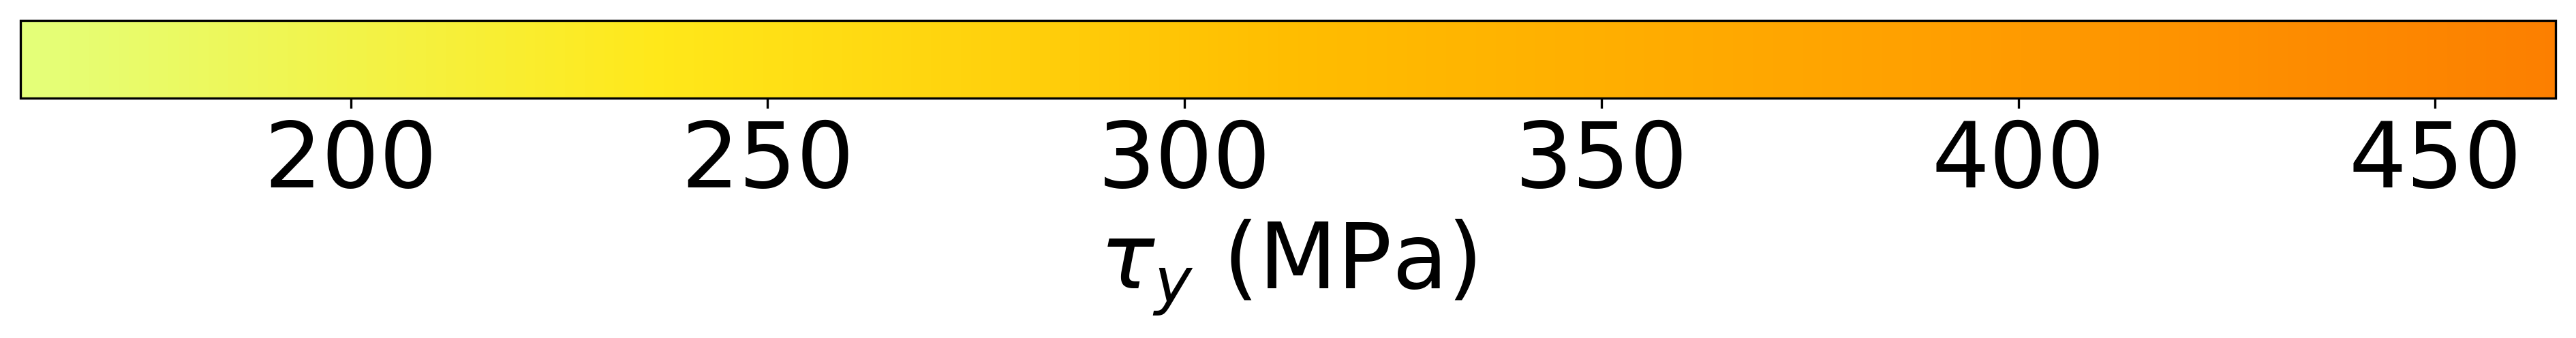

In [215]:
fig, ax = plt.subplots(figsize=(16, 1),dpi=300)
fig.subplots_adjust(bottom=0.5)
norm = mpl.colors.Normalize(vmin=min(model.calc_data['tau_y']),
                            vmax=max(model.calc_data['tau_y']))
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')
cb.set_label(label=r'$\tau_{y}$ (MPa)',size=32)
cb.ax.tick_params(labelsize=32)